In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_excel('Online_Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [15]:
df.dropna(subset=['CustomerID'], inplace=True)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [16]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [17]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalPrice     0
dtype: int64

In [18]:
analysis_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

Rec_freq_monetary = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (analysis_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()
Rec_freq_monetary.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
Rec_freq_monetary.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,2,0.00
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [19]:
Rec_freq_monetary['R_score'] = pd.qcut(Rec_freq_monetary['Recency'], 5, labels=[5,4,3,2,1]).astype(int)
Rec_freq_monetary['F_score'] = pd.qcut(Rec_freq_monetary['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
Rec_freq_monetary['M_score'] = pd.qcut(Rec_freq_monetary['Monetary'], 5, labels=[1,2,3,4,5]).astype(int)

Rec_freq_monetary['Recency_Frequency_Score'] = Rec_freq_monetary['R_score'] + Rec_freq_monetary['F_score'] + Rec_freq_monetary['M_score']
Rec_freq_monetary.head()

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,Recency_Frequency_Score
0,12346.0,326,2,0.00,1,2,1,4
1,12347.0,2,7,4310.00,5,4,5,14
2,12348.0,75,4,1797.24,2,3,4,9
3,12349.0,19,1,1757.55,4,1,4,9
4,12350.0,310,1,334.40,1,1,2,4


In [20]:
def segment_customer(score):
    if score >= 13:
        return 'Champions'
    elif score >= 10:
        return 'Loyal Customers'
    elif score >= 7:
        return 'Potential Loyalist'
    elif score >= 4:
        return 'At Risk'
    else:
        return 'Lost'
    
Rec_freq_monetary['Customer_Segment'] = Rec_freq_monetary['Recency_Frequency_Score'].apply(segment_customer)
Rec_freq_monetary.head()

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,Recency_Frequency_Score,Customer_Segment
0,12346.0,326,2,0.00,1,2,1,4,At Risk
1,12347.0,2,7,4310.00,5,4,5,14,Champions
2,12348.0,75,4,1797.24,2,3,4,9,Potential Loyalist
3,12349.0,19,1,1757.55,4,1,4,9,Potential Loyalist
4,12350.0,310,1,334.40,1,1,2,4,At Risk


C:\Users\Admin\AppData\Local\Temp\ipykernel_17320\725820682.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='Blues_d')


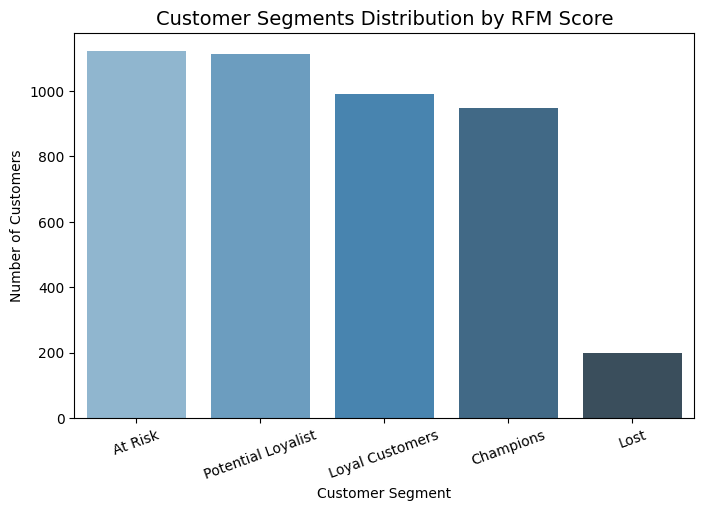

In [26]:
segment_counts = Rec_freq_monetary['Customer_Segment'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='Blues_d')
plt.title('Customer Segments Distribution by RFM Score', fontsize=14)
plt.xlabel('Customer Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=20)
plt.show()

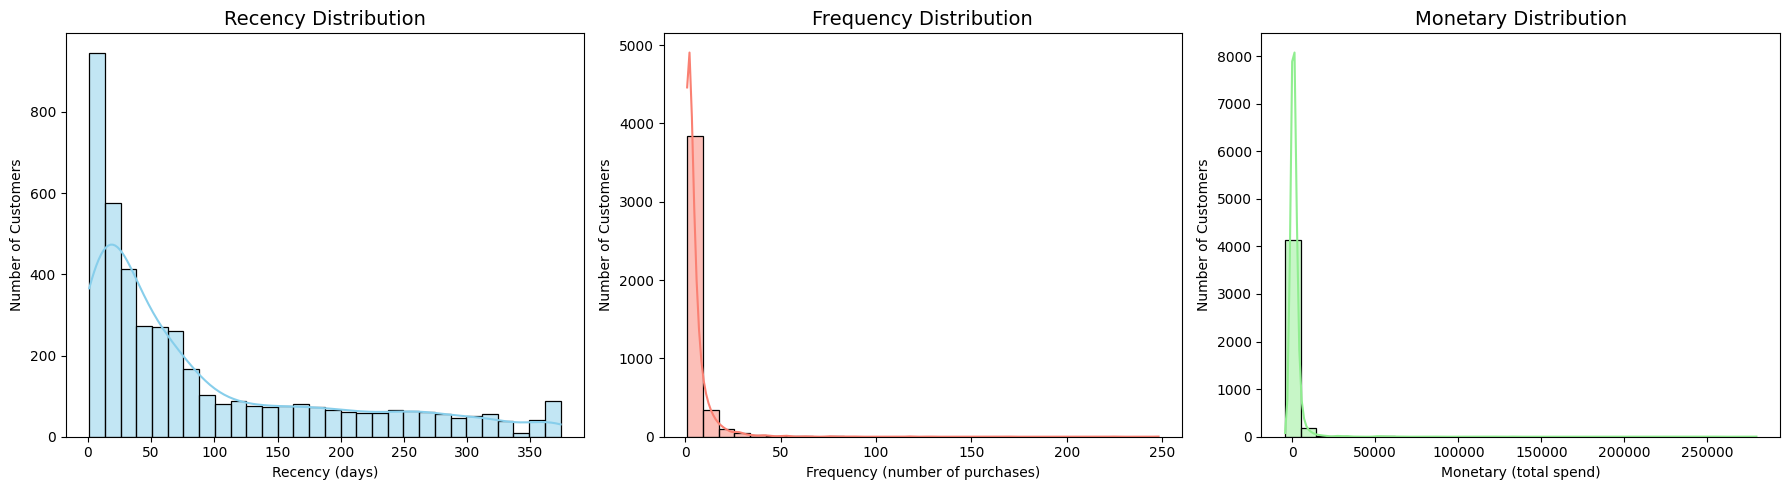

In [27]:
# RFM Distribution Visualization
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
sns.histplot(Rec_freq_monetary['Recency'], bins=30, kde=True, color='skyblue')
plt.title('Recency Distribution', fontsize=14)
plt.xlabel('Recency (days)')
plt.ylabel('Number of Customers')
plt.subplot(1,3,2)
sns.histplot(Rec_freq_monetary['Frequency'], bins=30, kde=True, color='salmon')
plt.title('Frequency Distribution', fontsize=14)
plt.xlabel('Frequency (number of purchases)')
plt.ylabel('Number of Customers')
plt.subplot(1,3,3)
sns.histplot(Rec_freq_monetary['Monetary'], bins=30, kde=True, color='lightgreen')
plt.title('Monetary Distribution', fontsize=14)
plt.xlabel('Monetary (total spend)')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.show()

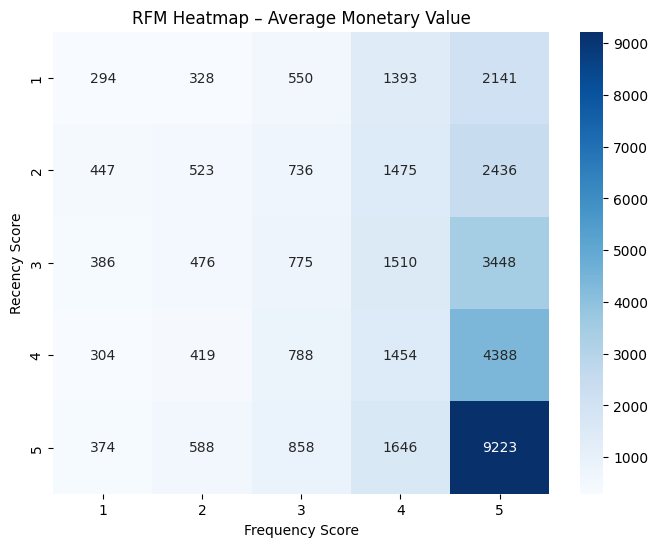

In [32]:
rfm_heatmap = Rec_freq_monetary.pivot_table(
    index='R_score', 
    columns='F_score', 
    values='Monetary', 
    aggfunc='mean'
)

plt.figure(figsize=(8,6))
sns.heatmap(rfm_heatmap, cmap='Blues', annot=True, fmt=".0f")
plt.title('RFM Heatmap – Average Monetary Value')
plt.xlabel('Frequency Score')
plt.ylabel('Recency Score')
plt.show()

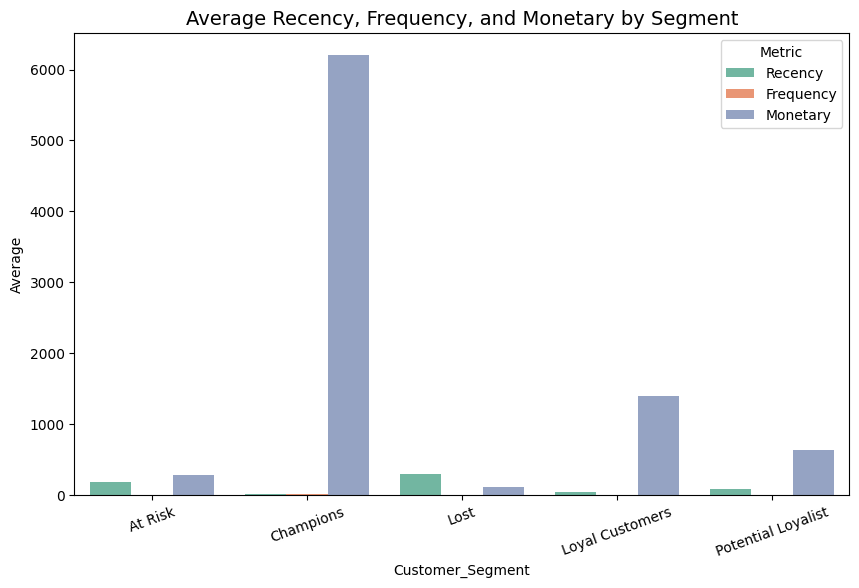

In [36]:
segment_avg = Rec_freq_monetary.groupby('Customer_Segment')[['Recency','Frequency','Monetary']].mean().reset_index()

segment_avg_melted = segment_avg.melt(id_vars='Customer_Segment', var_name='Metric', value_name='Average')
plt.figure(figsize=(10,6))
sns.barplot(data=segment_avg_melted, x='Customer_Segment', y='Average', hue='Metric', palette='Set2')
plt.title('Average Recency, Frequency, and Monetary by Segment', fontsize=14)
plt.xticks(rotation=20)
plt.show()


In [37]:
from mpl_toolkits.mplot3d import Axes3D

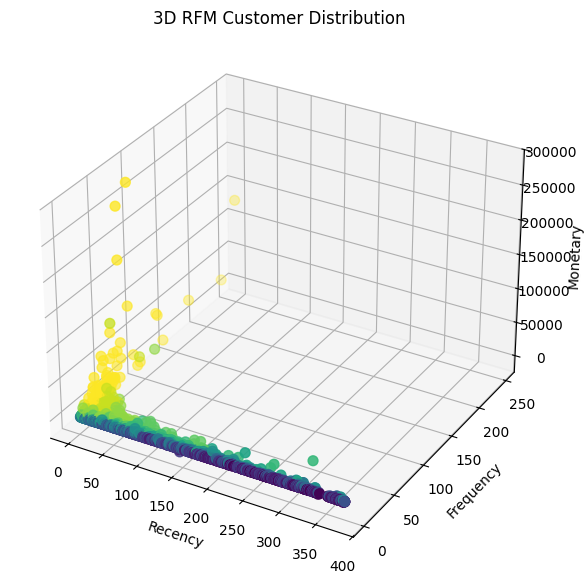

In [41]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Rec_freq_monetary['Recency'], Rec_freq_monetary['Frequency'], Rec_freq_monetary['Monetary'],
           c=Rec_freq_monetary['Recency_Frequency_Score'], cmap='viridis', s=50)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('3D RFM Customer Distribution')
plt.show()